In [1]:
import numpy as np
from glob import glob
import os
import gc
from pathlib import Path
import yaml

from matplotlib import pyplot as plt
from cycler import cycler
from matplotlib.backends.backend_pdf import PdfPages
plt.style.use('thesis')

from scipy.optimize import curve_fit
from scipy import stats

plt.rcParams.update({'figure.dpi': 150})
plt.rcParams.update({'axes.prop_cycle': cycler(color=['#5994cd', '#d74164', '#4eaa76', '#d88300', '#7365cf', \
                                                      '#c85e3e', '#83a23e', '#c851b1', '#1850a1'])})

from importlib import reload
import data_processing as dp

### Load the config file and add new parameters

In [27]:
drive_path = '/Users/clarke/Data'
# drive_path = '/Volumes/LaCie/'

sphere_date = '20251212'

base_path = f'{drive_path}/gas_collisions/pulse_calibration/sphere_{sphere_date}/'

if not os.path.exists(drive_path):
    print('Error: check that the external drive is plugged in!')

folders = glob(base_path + '*')

cal_datasets = {}

for folder in folders:
    # print(folder.split(base_path)[-1])
    all_items = glob(folder + '/*')
    subfolders = np.unique(['_'.join(s.split('_')[:-1]) for s in all_items])
    sub_datasets = []
    for subfolder in subfolders:
        sub_datasets.append(subfolder.split(base_path)[-1].split('/')[-1])
        # print('\t' + subfolder.split(base_path)[-1].split('/')[-1])
    cal_datasets[folder.split(base_path)[-1]] = sub_datasets

dataset_ind = 3
dataset = list(cal_datasets.keys())[dataset_ind]

with open(base_path + dataset + '/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

config['calibrate'] = False

template = np.array(config['template'])
resolution = config['resolution']

for key in config.keys():
    print(key + ':\t ', config[key])

apply_notch:	  True
calibrate:	  False
d_sphere_nm:	  166.0
f_cutoff:	  [25000.0, 100000.0]
fit_window:	  0.1
keV_per_N:	  1.7720025662458989e+19
meters_per_volt:	  5.3200812557904253e-08
resolution:	  119.61609032137251
search_window:	  5e-05
template:	  [-0.009432399836590633, -0.012439446477647524, -0.018127937203492376, -0.026187452042251175, -0.027844987090906794, -0.015057205926101005, 0.00981580060517759, 0.03471787131004821, 0.04997025616031445, 0.05619959826420232, 0.060211096700331604, 0.06355310863758974, 0.05987164189244362, 0.0434079932291113, 0.019445193447618095, 0.001471134492009923, -0.006189159117720636, -0.028122676216909684, -0.11207961548025328, -0.28172752932862455, -0.47122242981361334, -0.5167520726438919, -0.26344607966247696, 0.2629913698182462, 0.7928277216876306, 0.9796750170813773, 0.6872049928026693, 0.11249448005619789, -0.3853708668872827, -0.5730432334040604, -0.47099819640129764, -0.2550576990111581, -0.08208793181491991, -0.002462592124882735, 0.01564

### List the background datasets

In [28]:
base_path = f'{drive_path}/gas_collisions/background_data/sphere_{sphere_date}/'

folders = glob(base_path + '*')

bkg_datasets = {}

for folder in folders:
    print(folder.split(base_path)[-1])
    all_items = glob(folder + '/*')
    subfolders = np.unique(['_'.join(s.split('_')[:-1]) for s in all_items])
    sub_datasets = []
    for subfolder in subfolders:
        sub_datasets.append(subfolder.split(base_path)[-1].split('/')[-1])
        print('\t' + subfolder.split(base_path)[-1].split('/')[-1])
    bkg_datasets[folder.split(base_path)[-1]] = sub_datasets

20251216_unknown_6e-8mbar
	20251216_df
20251217_unknown_5e-8mbar_kryptonpumped
	20251217_df
20251216_unknown_5e-8mbar_cryopumped
	20251216_df
20251218_p8e_1e-7mbar_noinjection
	20251218_df
20251218_p8e_7e-8mbar_noinjection
	20251218_df
20251215_p8e_5e-8mbar
	20251215_df
20251216_unknown_6e-8mbar_cryopumped
	20251216_df


### Load a background dataset

In [29]:
reload(dp)

# choose which dataset to look at
dataset_ind = 1
dataset = list(bkg_datasets.keys())[dataset_ind]

plot = False

plot_path = 'figures/' + base_path.split(drive_path)[-1] + dataset + '/' + bkg_datasets[dataset][0] if plot else None
nd = dp.NanoDataset(base_path + dataset + '/' + bkg_datasets[dataset][0], plot_path, verbose=True, max_files=10, \
                    config=config, ds_factor=10)
nd.load_search_data()
# nd.save_to_hdf5()

Loading files starting with
/Users/clarke/Data/gas_collisions/background_data/sphere_20251212/20251217_unknown_5e-8mbar_kryptonpumped/20251217_df
  Loading file 1...
  Loading file 2...
  Loading file 3...
  Loading file 4...
  Loading file 5...
  Loading file 6...
  Loading file 7...
  Loading file 8...
  Loading file 9...
  Loading file 10...


In [140]:
# nd2 = dp.NanoDataset()
# nd2.load_from_hdf5(base_path + dataset + '/' + bkg_datasets[dataset][0] + '_processed.hdf5')

### Cut away noisy periods

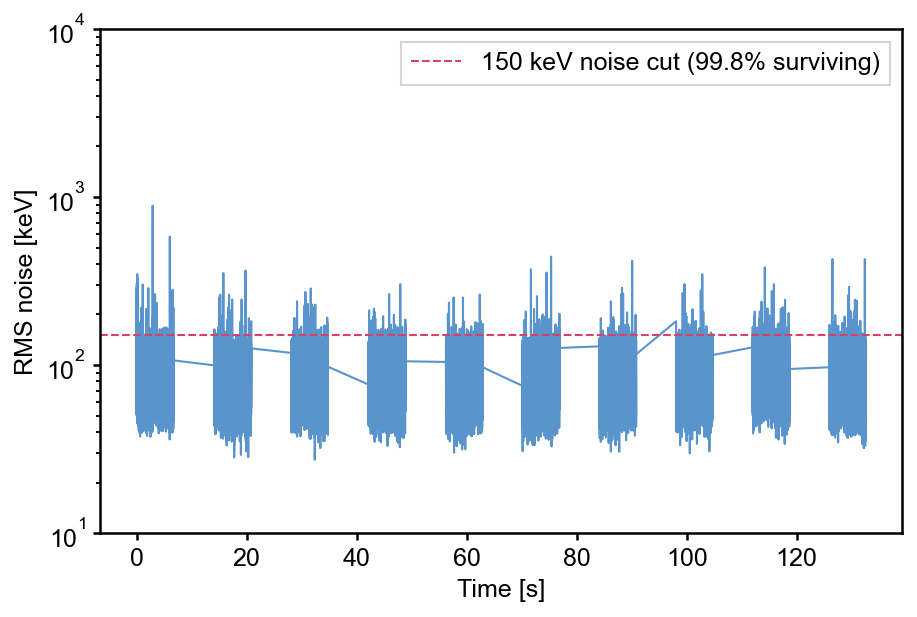

In [6]:
noise_thresh = 150 # keV

noise_cut = (nd.impulse_rms < noise_thresh) & (nd.impulse_rms > 10)

# also cut based on the fit to the resonance
res_cut = nd.resonance_params[:, 2] < 2*np.pi*100

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
ax.semilogy(nd.pulse_times, nd.impulse_rms)
ax.axhline(noise_thresh, ls='--', color='C1', label='{:.0f} keV noise cut ({:.1f}% surviving)'\
                                                    .format(noise_thresh, 100*sum(noise_cut)/len(noise_cut)))
ax.set_xlabel('Time [s]')
ax.set_ylabel('RMS noise [keV]')
ax.set_ylim([1e1, 1e4])
ax.legend(loc='upper right')

### Cut based on goodness of fit

In [7]:
z_cut = 1
ndof = len(template) - 1
alpha = (1 - stats.norm.cdf(z_cut))*2

pvals = 1. - stats.chi2.cdf(nd.chi2, df=ndof)
chi2_cut = np.zeros(nd.chi2.shape, dtype=bool)
chi2_cut[pvals > alpha] = True

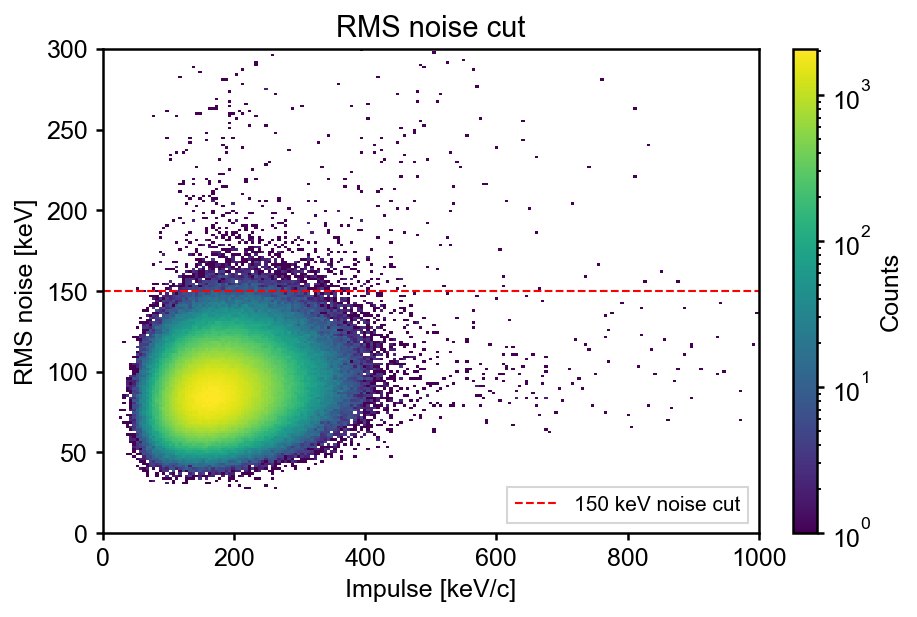

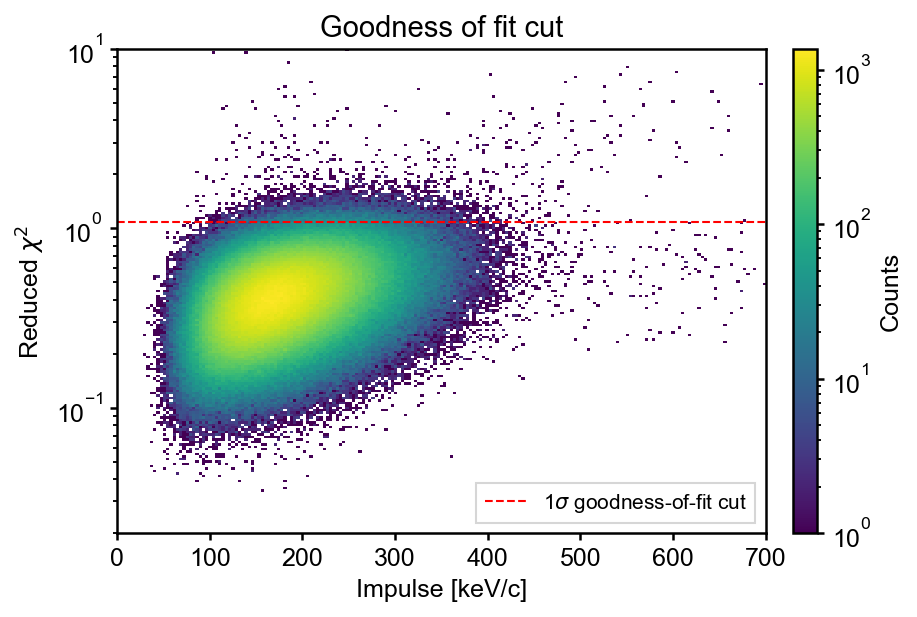

In [8]:
fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
bins_y = np.linspace(0, 300, 200)
bins_x = np.linspace(0, 1000, 200)
h = ax.hist2d(np.abs(nd.impulses), nd.impulse_rms, bins=(bins_x, bins_y), norm='log')
ax.axhline(noise_thresh, ls='--', color='red', label='{:.0f} keV noise cut'.format(noise_thresh))
ax.set_xlabel('Impulse [keV/c]')
ax.set_ylabel('RMS noise [keV]')
ax.legend(fontsize=10, loc='lower right')
ax.set_title('RMS noise cut')
fig.colorbar(h[3], ax=ax, label='Counts', pad=0.01)

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
bins_y = np.logspace(np.log10(2e-2), 1, 200)
bins_x = np.linspace(0, 700, 200)
h = ax.hist2d(np.abs(nd.impulses), nd.chi2/ndof, bins=(bins_x, bins_y), norm='log')
ax.axhline(stats.chi2.ppf(1 - alpha, ndof)/ndof, ls='--', color='red', label=r'{:.0f}$\sigma$ goodness-of-fit cut'.format(z_cut))
ax.set_yscale('log')
ax.set_xlabel('Impulse [keV/c]')
ax.set_ylabel(r'Reduced $\chi^2$')
ax.legend(fontsize=10, loc='lower right')
ax.set_title('Goodness of fit cut')
fig.colorbar(h[3], ax=ax, label='Counts', pad=0.01)

### Histogram the results

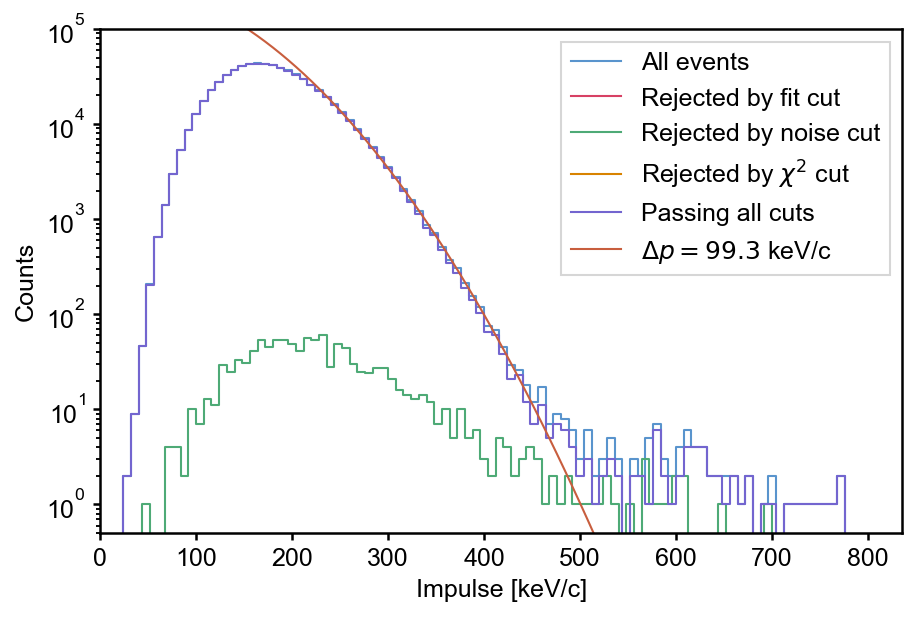

In [9]:
bin_edges = np.linspace(0, 800, 101)

counts_all, _ = np.histogram(nd.impulses, bins=bin_edges)
counts_acc, _ = np.histogram(nd.impulses[chi2_cut & noise_cut], bins=bin_edges)

bins = (bin_edges[1:] + bin_edges[:-1])/2.

ppb = len(nd.impulses)/len(bins)
exp = np.floor(np.log10(ppb))
coeff = 5*np.ceil(ppb/10**exp)

fit_ind = int(1.5*np.argmax(counts_all))

def half_gaus(x, A, sigma):
    return A*np.exp(-x**2/2/sigma**2)

p, _ = curve_fit(half_gaus, bins[fit_ind:], counts_acc[fit_ind:], p0=(ppb, np.std(nd.impulses[~np.isnan(nd.impulses)])))

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
ax.step(bins, counts_all, where='mid', label='All events')
ax.step(bins, np.histogram(nd.impulses[~res_cut], bins=bin_edges)[0], label='Rejected by fit cut')
ax.step(bins, np.histogram(nd.impulses[~noise_cut & res_cut], bins=bin_edges)[0], label='Rejected by noise cut')
ax.step(bins, np.histogram(nd.impulses[~chi2_cut & noise_cut & ~res_cut], bins=bin_edges)[0], label=r'Rejected by $\chi^2$ cut')
ax.step(bins, counts_acc, where='mid', label='Passing all cuts')
ax.plot(bins, half_gaus(bins, *p), label='$\\Delta p={:.1f}$ keV/c'.format(np.abs(p[1])))
ax.set_xlim([0, 1.05*np.amax(bins)])
ax.set_ylim([5e-1, coeff*10**exp])
ax.set_xlabel('Impulse [keV/c]')
ax.set_ylabel('Counts')
ax.set_yscale('log')
ax.legend()

counts_bkg = np.copy(counts_acc)
imp_spec_bkg = np.copy(bins)